# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [2]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y, [0, 1])
X_filtered = X[mask]
y_filtered = y[mask]

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
Accuracy: 0.9836
Confusion Matrix:
[[1370   30]
 [  16 1384]]


/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python

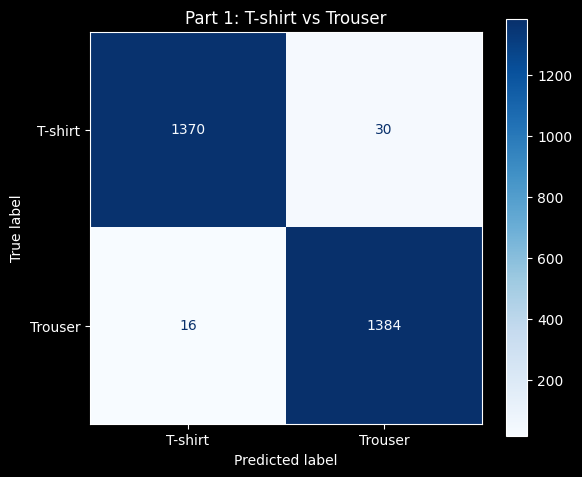

In [3]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [4]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# Load data, filter to labels 5, 7, 9
X, y = load_fashion_mnist()
mask = np.isin(y, [5, 7, 9])
X_filtered = X[mask]
y_filtered = y[mask]

# Encode labels to 0, 1, 2 (required for XGBoost)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        objective='multi:softprob',
        eval_metric='mlogloss'
    )
}

# Run 5-fold CV for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    for fold, score in enumerate(scores, 1):
        cv_results.append({'model': name, 'fold': fold, 'score': score})

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, 'part2_cv_results.csv'), index=False)

# Find best model by mean CV score and retrain on full training data
mean_scores = cv_df.groupby('model')['score'].mean()
best_model_name = mean_scores.idxmax()
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Evaluate on test set and save classification report
y_pred = best_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, 'part2_test_results.csv'))

print(f'Best model: {best_model_name}')
print(f'Mean CV accuracy: {mean_scores[best_model_name]:.4f}')


Part 2: Multi-class Classification with CV
----------------------------------------


/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/zefanhuang/Downloads/05-stay-classy-Zefan-Huang/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.

Best model: XGBoost
Mean CV accuracy: 0.9670


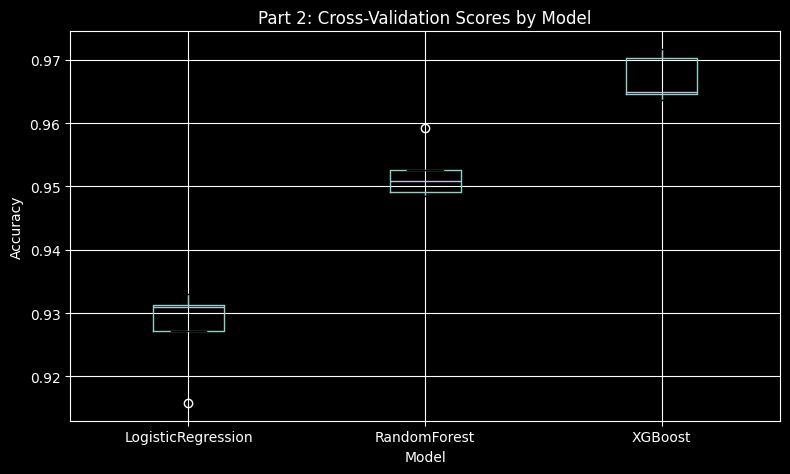

In [5]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_df.boxplot(column='score', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [ ]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# Load data and filter out bags (label 8)
X, y = load_fashion_mnist()
mask = y != 8
X_filtered = X[mask]
y_original = y[mask]

# Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
y_binary = np.isin(y_original, [5, 7, 9]).astype(int)

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss'
    )
}

# Run 5-fold CV for all models using the same splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    auc_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    for fold, auc in enumerate(auc_scores, 1):
        cv_results.append({'model': name, 'fold': fold, 'auc': auc})

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, 'part3_cv_results.csv'), index=False)

# Find best model by mean AUC
mean_auc = cv_df.groupby('model')['auc'].mean()
best_model_name = mean_auc.idxmax()
best_model = models[best_model_name]

# Train all models on full training data (needed for ROC curves)
trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

# Generate ROC curves
plot_roc_curves(trained_models, X_test_scaled, y_test, os.path.join(OUTPUT_DIR, 'part3_roc_curves.png'))

# Evaluate best model on test set
best_trained_model = trained_models[best_model_name]
y_pred = best_trained_model.predict(X_test_scaled)
y_prob = best_trained_model.predict_proba(X_test_scaled)[:, 1]
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

# Generate confusion matrix
plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], os.path.join(OUTPUT_DIR, 'part3_confusion_matrix.png'))

# Save test results
test_results = pd.DataFrame([{
    'model': best_model_name,
    'accuracy': test_accuracy,
    'auc': test_auc
}])
test_results.to_csv(os.path.join(OUTPUT_DIR, 'part3_test_results.csv'), index=False)

print(f'Best model: {best_model_name}')
print(f'Mean CV AUC: {mean_auc[best_model_name]:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')

---

## Validation

In [ ]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")